#### Overview
- Reproducing https://medium.com/@dave.cote.msc/hybrid-multimodal-neural-network-architecture-combination-of-tabular-textual-and-image-inputs-7460a4f82a2e
- This script uses a transfer-learned Logistic Regression model (from VGG16 modelas a feature extractor) to predict every image we have into "good" or "bad" images
- Output: img_pred_bad.csv
- Rows with "bad" images in the tabular data will be removed

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import pickle

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

# other imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

2023-07-22 13:14:08.308130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-22 13:14:12.610368: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-22 13:14:12.612483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 13:14:18.282739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Use VGG16 model without the top layer to extract the image features 

In [2]:
#User Input 
config={
  "feature_extractor_model" : "vgg16",
  "weights"         : "imagenet",
  "include_top"     : False,
  "classifier_model": "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/classifier.pickle",
  "pred_path"       : "/workspaces/deeplearning-multimodal-neural-network/data/homeimages/",
  "results"         : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/results.csv",
  "image_size"      : (224, 224)
}

In [33]:
# config variables
feature_extractor_model = config["feature_extractor_model"]
feature_extractor_weights = config["weights"]
classifier_model = config["classifier_model"]
pred_path = config["pred_path"]
results_path = config["results"]

if feature_extractor_model == "vgg16":
    base_model = VGG16(weights=feature_extractor_weights)#, include_top=True)
    fe_model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
    image_size = (224, 224)
else:
    base_model = None

#Load previously trained model
tl_model = pickle.load(open(classifier_model, 'rb'))

print ("Successfully loaded feature extractor and transfer-learned models...")

Successfully loaded feature extractor and transfer-learned models...


Prototyping with one image, also inspect its preprocessed feature

(224, 224)
(224, 224, 3)


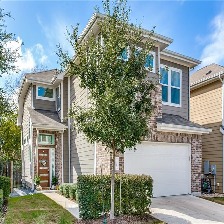

In [34]:
l_images = os.listdir(pred_path)
img = image.load_img(pred_path + l_images[1], target_size=image_size) #224x224
print(img.size)
a_img = image.img_to_array(img) #50176
print(a_img.shape)
img.show()

(1, 224, 224, 3)


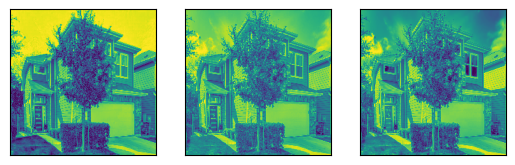

In [35]:
#Inspect preprocessed image
a_img = np.expand_dims(a_img, axis=0)
print(a_img.shape)
a_img = preprocess_input(a_img)

from matplotlib import pyplot 
ix = 1
for _ in range(3):
	# specify subplot and turn of axis
    ax = pyplot.subplot(1, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(a_img[0, :, :, ix-1], cmap='viridis')
    ix += 1
# show the figure
pyplot.show()

Extract the feature of the preprocessed image. There should be 4096 features

In [43]:
feature = fe_model.predict(a_img)
print(feature.shape)
print(feature[:,0])
print(feature[:,1])
print(feature[:,1000])

1/1 [==============================] - 0s 198ms/step
(1, 4096)
[0.]
[0.07130233]
[14.745974]


Classify the preprocessed image to one of the two classes [1] Good because it shows a house, or [0] Bad because it doesn't show the structure of a house

In [44]:
pred = tl_model.predict(feature)
print(pred)

[1]


#### Let's split the images to Goods' and Bads'
Save the predictions in a parquet file

In [45]:
import pyarrow as pa
# import pyarrow.parquet as pp

In [60]:
chunksize = 1e3
data = []
fields = [('filename', pa.string()), ('pred', pa.int64())]#list of tuples
schema = pa.schema(fields)

#variable to hold processed images
l_preds = []
l_images = []
l_images_all = os.listdir(pred_path)
# l_images_all = l_images_dummy[0:int(chunksize)+1]
# l_images_all = l_images_dummy[0:10]

In [61]:
with pa.parquet.ParquetWriter('image_cleaner_result', schema=schema) as writer:
    #loop over all the labels in the folder
    counter = 0
    for filename in l_images_all:
        img = image.load_img(pred_path + filename, target_size=image_size) #(1, 224, 224, 3)
        a_img = image.img_to_array(img) #(224, 224, 3)
        a_img = np.expand_dims(a_img, axis=0) #(1, 224, 224, 3)
        a_img = preprocess_input(a_img)
        feature = fe_model.predict(a_img)
        pred = tl_model.predict(feature) # #Prediction
        l_preds.append(pred)
        l_images.append(filename)
        counter += 1
        if counter == int(chunksize):
            data = pd.DataFrame({'filename':l_images, 'pred':l_preds})
            t_data = pa.Table.from_pandas(data, schema=schema)
            writer.write_table(t_data)
            data=[]
            l_preds = []
            l_images = []
            print("Saved a chunk at file:")
            print(counter)
    if len(l_preds) !=0:
        data = pd.DataFrame({'filename':l_images, 'pred':l_preds})
        t_data = pa.Table.from_pandas(data, schema=schema)
        writer.write_table(t_data)
writer.close()


1/1 [==============================] - 0s 173ms/step


In [62]:
df_temp = pd.read_parquet("/workspaces/deeplearning-multimodal-neural-network/demo/image_cleaner_result")
df_temp

,filename,pred
0,29466933_daa90905262f5dfd92de9e4e58debf37-p_f.jpg,0
1,125090848_728406db697bfff18989407b96b21ab6-p_f...,1
2,29493307_4f50604323b4ee8b2ef064903b4dfaf8-p_f.jpg,1
3,29445437_602df9860971cfd27b120f44011a6702-p_f.jpg,1
4,29359483_e27ecbe3fe06efdc0a4adacaa6605623-p_f.jpg,1
5,29367646_338c96537a256bcc9272b78ab42b122d-p_f.jpg,1
6,63228572_014d82ccb51dc09d5227b002138ca55b-p_f.jpg,1
7,29377504_streetviewlocation11321RockwellCt2CAu...,0
8,29470310_958cf4ec91188518d24f6ec383600b4b-p_f.jpg,1
9,29509519_e623e68a1f999a794526529ac9907b85-p_f.jpg,1


In [9]:
#variable to hold processed images
l_preds = []

#loop over all the labels in the folder
l_images = os.listdir(pred_path)
for filename in l_images:
    img = image.load_img(pred_path + filename, target_size=image_size) #(1, 224, 224, 3)
    #img = image.load_img(pred_path + filename, color_mode='grayscale', target_size=image_size) #224x224
    a_img = image.img_to_array(img) #(224, 224, 3)
    # 't' is a tensor of shape [2], tf.shape(tf.expand_dims(t, 0))  # [1, 2] | https://ai-mrkogao.github.io/tensorflow/tfexpanddims/
    a_img = np.expand_dims(a_img, axis=0) #(1, 224, 224, 3)
    a_img = preprocess_input(a_img)
    feature = fe_model.predict(a_img)
    #a_img = a_img.flatten()
    # #Prediction
    pred = tl_model.predict(feature)
    l_preds.append(pred)


1/1 [==============================] - 0s 177ms/step


: 

: 

In [ ]:
#Combine two lists into a dataframe
df_img_pred = pd.DataFrame({'filename':l_images,
                            'prediction': l_preds
                            })

df_img_pred.to_csv(results_path, sep=',', index=False)
